### Ingest math and language arts state test participation 

In [1]:
# Look at columns in files one at a time before we upload to worm
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
dataset_dir = "/home/bb/datasets/state_test_participation/"

math_files = []
rla_files = []
for root, dirs, files in os.walk(dataset_dir, topdown=False):
    for f in files:
        if f.startswith("math"):
            math_files += [f]
        if f.startswith("rla"):
            rla_files += [f]
        print(f)


math-participation-sch-sy2018-19-wide.csv
rla-participation-sch-sy2012-13.csv
rla-participation-sch-sy2015-16.csv
math-participation-sch-sy2016-17.csv
math-participation-sch-sy2012-13.csv
math-participation-sch-sy2014-15.csv
math-participation-sch-sy2013-14.csv
rla-participation-sch-sy2018-19-wide.csv
rla-participation-sch-sy2017-18.csv
math-participation-sch-sy2015-16.csv
rla-participation-sch-sy2016-17.csv
rla-participation-sch-sy2013-14.csv
math-participation-sch-sy2017-18.csv
rla-participation-sch-sy2014-15.csv


In [3]:
# We are missing the years 2010-2011 and 2011-2012. Possibly we can impute the values.
# Lets look at the feature overlap


In [4]:
# We have 7 years of Math percent participated scores
len(math_files), len(rla_files)


(7, 7)

In [5]:
# Create raw math and rla dataframe lists
math_dfs = [pd.read_csv(dataset_dir + "/" + i, low_memory=False)
            for i in math_files]
rla_dfs = [pd.read_csv(dataset_dir + "/" + i, low_memory=False)
           for i in rla_files]


In [6]:
# Example of the shape of one of the datrames
math_dfs[0].shape, math_dfs[0].columns.tolist()


((90320, 265),
 ['STNAM',
  'FIPST',
  'LEANM',
  'LEAID',
  'ST_LEAID',
  'NCESSCH',
  'ST_SCHID',
  'SCHNAM',
  'DATE_CUR',
  'ALL_MTH00numpart_1819',
  'ALL_MTH00pctpart_1819',
  'MAM_MTH00numpart_1819',
  'MAM_MTH00pctpart_1819',
  'MAS_MTH00numpart_1819',
  'MAS_MTH00pctpart_1819',
  'MBL_MTH00numpart_1819',
  'MBL_MTH00pctpart_1819',
  'MHI_MTH00numpart_1819',
  'MHI_MTH00pctpart_1819',
  'MTR_MTH00numpart_1819',
  'MTR_MTH00pctpart_1819',
  'MWH_MTH00numpart_1819',
  'MWH_MTH00pctpart_1819',
  'F_MTH00numpart_1819',
  'F_MTH00pctpart_1819',
  'M_MTH00numpart_1819',
  'M_MTH00pctpart_1819',
  'CWD_MTH00numpart_1819',
  'CWD_MTH00pctpart_1819',
  'ECD_MTH00numpart_1819',
  'ECD_MTH00pctpart_1819',
  'FCS_MTH00numpart_1819',
  'FCS_MTH00pctpart_1819',
  'LEP_MTH00numpart_1819',
  'LEP_MTH00pctpart_1819',
  'HOM_MTH00numpart_1819',
  'HOM_MTH00pctpart_1819',
  'MIG_MTH00numpart_1819',
  'MIG_MTH00pctpart_1819',
  'MIL_MTH00numpart_1819',
  'MIL_MTH00pctpart_1819',
  'ALL_MTH03numpar

In [7]:
# Inspecting the codebook, we see that there are only two columns relevant to our study.
# These are the percentage participation numbers in math and reading / language arts state assessments.
# Extract the total participation column names that are relevant to high schools
list(map(lambda x: print(x.filter(like="ALL_MTHHSPCT").columns), math_dfs))
list(map(lambda x: print(x.filter(like="ALL_RLAHSPCT").columns), rla_dfs))
list(map(lambda x: print(x.filter(like="NCESSCH").columns), math_dfs))
list(map(lambda x: print(x.filter(like="NCESSCH").columns), rla_dfs))


Index([], dtype='object')
Index(['ALL_MTHHSPCTPART_1617'], dtype='object')
Index(['ALL_MTHHSPCTPART_1213'], dtype='object')
Index(['ALL_MTHHSPCTPART_1415'], dtype='object')
Index(['ALL_MTHHSPCTPART_1314'], dtype='object')
Index(['ALL_MTHHSPCTPART_1516'], dtype='object')
Index(['ALL_MTHHSPCTPART_1718'], dtype='object')
Index(['ALL_RLAHSPCTPART_1213'], dtype='object')
Index(['ALL_RLAHSPCTPART_1516'], dtype='object')
Index([], dtype='object')
Index(['ALL_RLAHSPCTPART_1718'], dtype='object')
Index(['ALL_RLAHSPCTPART_1617'], dtype='object')
Index(['ALL_RLAHSPCTPART_1314'], dtype='object')
Index(['ALL_RLAHSPCTPART_1415'], dtype='object')
Index(['NCESSCH'], dtype='object')
Index(['NCESSCH'], dtype='object')
Index(['NCESSCH'], dtype='object')
Index(['NCESSCH'], dtype='object')
Index(['NCESSCH'], dtype='object')
Index(['NCESSCH'], dtype='object')
Index(['NCESSCH'], dtype='object')
Index(['NCESSCH'], dtype='object')
Index(['NCESSCH'], dtype='object')
Index(['NCESSCH'], dtype='object')
Index(['NC

[None, None, None, None, None, None, None]

### Strategy:
* Subset the dataframes to our columns of interest e.g. (NCESSCH, ALL_MTHHSPCTPART_1213, ALL_RLAHSPCTPART_1213)
* Create one large math and one large language arts dataframe with all the years stacked, so that it matches our graduation rate and school directory dataframes
* Explore statistics and missing values
* Save these two dataframes to disk

In [8]:
def year_string(y: int):
    """Input an integer year and get a range that matches the column suffixes in the raw data.
    e.g. 2011 => 1112 and 2018 => 1819."""
    return str(y)[-2:] + str(int(str(y)[-2:]) + 1)


In [9]:
# Produce large dataframes joined by year

new_math_dfs = []
new_rla_dfs = []

for df in math_dfs:
    pct_part = df.loc[:, [
        'ALL_MTHHSPCT' in i or 'ALL_MTHHSpct' in i for i in df.columns]]
    unaltered_year = pct_part.columns[0][-4:]
    year = int("20" + pct_part.columns[0][-4:-2])
    year_df = pd.DataFrame()
    year_df['Year'] = np.array([year] * len(pct_part))
    ncessch = df.filter(like='NCESSCH')
    pct_part.rename(mapper={"ALL_MTHHSPCTPART_" +
                    unaltered_year: "Math_Pct_Part"}, axis=1, inplace=True)
    pct_part.rename(mapper={"ALL_MTHHSpctpart_" +
                    unaltered_year: "Math_Pct_Part"}, axis=1, inplace=True)
    assert isinstance(pct_part, pd.DataFrame)
    assert isinstance(year_df, pd.DataFrame)
    assert isinstance(ncessch, pd.DataFrame)
    assert len(pct_part) == len(year_df) == len(ncessch)
    new_df = pd.concat([year_df, ncessch, pct_part], axis=1)
    new_math_dfs += [new_df]


for df in rla_dfs:
    pct_part = df.loc[:, [
        'ALL_RLAHSPCT' in i or 'ALL_RLAHSpct' in i for i in df.columns]]
    unaltered_year = pct_part.columns[0][-4:]
    year = int("20" + pct_part.columns[0][-4:-2])
    year_df = pd.DataFrame()
    year_df['Year'] = np.array([year] * len(pct_part))
    ncessch = df.filter(like='NCESSCH')
    pct_part.rename(mapper={"ALL_RLAHSPCTPART_" +
                    unaltered_year: "Rla_Pct_Part"}, axis=1, inplace=True)
    pct_part.rename(mapper={"ALL_RLAHSpctpart_" +
                    unaltered_year: "Rla_Pct_Part"}, axis=1, inplace=True)
    assert isinstance(pct_part, pd.DataFrame)
    assert isinstance(year_df, pd.DataFrame)
    assert isinstance(ncessch, pd.DataFrame)
    assert len(pct_part) == len(year_df) == len(ncessch)
    new_df = pd.concat([year_df, ncessch, pct_part], axis=1)
    new_rla_dfs += [new_df]


/tmp/ipykernel_339332/2146115944.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pct_part.rename(mapper={"ALL_MTHHSPCTPART_" +
/tmp/ipykernel_339332/2146115944.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pct_part.rename(mapper={"ALL_MTHHSpctpart_" +
/tmp/ipykernel_339332/2146115944.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pct_part.rename(mapper={"ALL_MTHHSPCTPART_" +
/tmp/ipykernel_339332/2146115944.py:16: Set

In [10]:
# Investigate big_math_dfs and big_rla_df
[i.shape for i in new_math_dfs]


[(90320, 3),
 (90838, 3),
 (89593, 3),
 (87597, 3),
 (88213, 3),
 (89606, 3),
 (88936, 3)]

In [11]:
big_math_df = pd.concat(new_math_dfs, axis=0)
big_rla_df = pd.concat(new_rla_dfs, axis=0)



In [12]:
# Merge RLA and PCT prof on 'Year' and 'Ncessch"
merged_data = big_math_df.merge(big_rla_df, how='left', on=["Year", "NCESSCH"])


In [13]:
merged_data


,Year,NCESSCH,Math_Pct_Part,Rla_Pct_Part
0,2018,10000500870,NaN,NaN
1,2018,10000500871,98,98
2,2018,10000500879,NaN,NaN
3,2018,10000500889,NaN,NaN
4,2018,10000600193,NaN,NaN
...,...,...,...,...
625098,2017,560609000401,GE90,GE90
625099,2017,560624000343,GE95,GE95
625100,2017,560624000344,NaN,NaN
625101,2017,560624000577,NaN,NaN


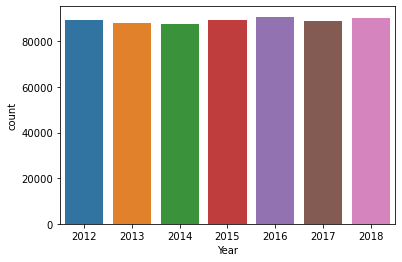

In [14]:
# Explore Percent Participation, Year, and Ncessch
sns.countplot(data=merged_data, x='Year')
plt.rcParams['figure.figsize'] = (8, 8)


<AxesSubplot:xlabel='count', ylabel='Rla_Pct_Part'>

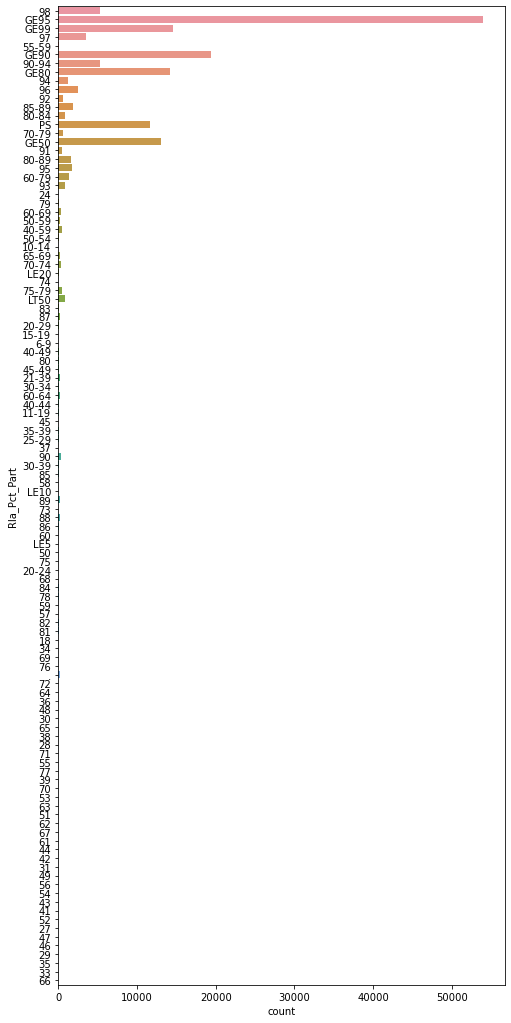

In [15]:
plt.rcParams['figure.figsize'] = (8, 18)
sns.countplot(data=merged_data, y='Rla_Pct_Part')


<AxesSubplot:xlabel='count', ylabel='Math_Pct_Part'>

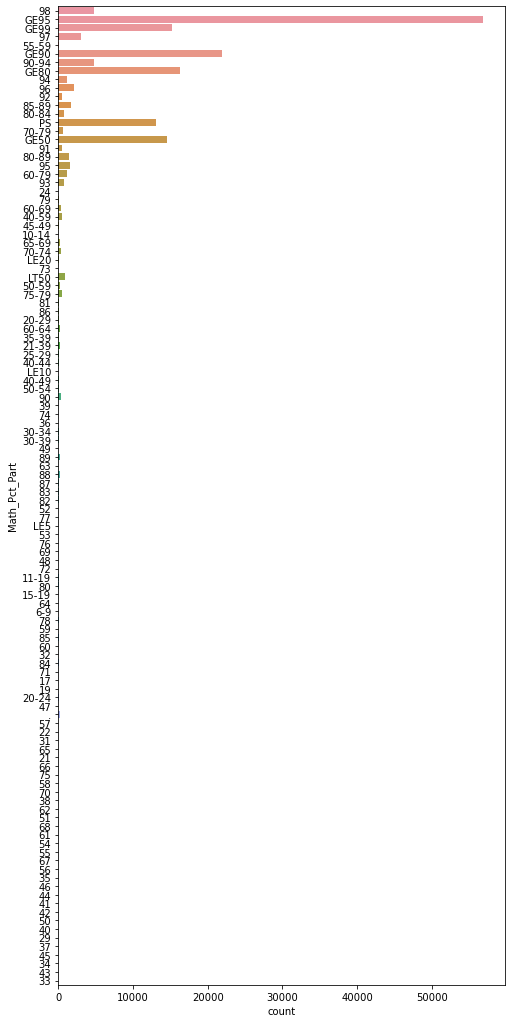

In [16]:
plt.rcParams['figure.figsize'] = (8, 18)
sns.countplot(data=merged_data, y='Math_Pct_Part')


Observation
There are 12-15000 schools with a 'PS' for percent participated, indicating that they had such small graduating cohorts that they were not included in the study. Note that schools marked with PS in the graduation rate dataset were dropped due to not having a valid target variable value to train or test a model on.

In [17]:
merged_data


,Year,NCESSCH,Math_Pct_Part,Rla_Pct_Part
0,2018,10000500870,NaN,NaN
1,2018,10000500871,98,98
2,2018,10000500879,NaN,NaN
3,2018,10000500889,NaN,NaN
4,2018,10000600193,NaN,NaN
...,...,...,...,...
625098,2017,560609000401,GE90,GE90
625099,2017,560624000343,GE95,GE95
625100,2017,560624000344,NaN,NaN
625101,2017,560624000577,NaN,NaN


In [18]:
merged_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 625103 entries, 0 to 625102
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Year           625103 non-null  int64 
 1   NCESSCH        625103 non-null  int64 
 2   Math_Pct_Part  170295 non-null  object
 3   Rla_Pct_Part   161320 non-null  object
dtypes: int64(2), object(2)
memory usage: 23.8+ MB


In [19]:
# @TODO: Need to convert the stringified numerical values in the Pct_Part columns to numeric values. We can use the function from the graduation rate 
# EDA notebook to do this.

In [20]:
# Helper functions to convert ranges given in ALL_RATE_ column to a trivially convertible string 
def conv_range_to_numeric_string(t: str):
    """Take in a numeric range given as a string, e.g. "10-20" and return the midpoint as a string."""
    vals = t.split("-")
    if len(vals) == 2:
        val1, val2 = float(vals[0]), float(vals[1])
        new_val = val1 / 2.0 + val2 / 2.0
        return str(new_val)
    else:
        # If a range with a dash in it is not found, return original string unchanged.
        return t

assert conv_range_to_numeric_string('95-95') == '95.0'
assert conv_range_to_numeric_string('105-110') == '107.5'
assert conv_range_to_numeric_string('90') == '90'

def strip_prefixed_string(t: str):
    """
    Convert prefixed numbers to a string of a number in the midpoint of their range 
    """
    if t.startswith('GT'):
        t = t.removeprefix('GT')
        t = float(t)
        t = sum([t, 100.0])/2.0
        return str(t)
    elif t.startswith('GE'):
        t = t.removeprefix('GE')
        t = float(t)
        t = sum([t, 100.0])/2.0
        return str(t)
    elif t.startswith('LT'):
        t = t.removeprefix('LT')
        t = float(t)
        t = sum([t, 0])/2.0
        return str(t)
    elif t.startswith('LE'):
        t = t.removeprefix('LE')
        t = float(t)
        t = sum([t, 0])/2.0
        return str(t)
    # If one of the prefixes is not found, return original string unchanged
    return t

assert strip_prefixed_string('GE50') == '75.0'
assert strip_prefixed_string('GT50') == '75.0'
assert strip_prefixed_string('LE90') == '45.0'
assert strip_prefixed_string('LT90') == '45.0'
assert strip_prefixed_string('95-95') == '95-95'

In [21]:
# Convert missing values to NAN
merged_data.replace('PS',np.nan,inplace=True)
merged_data.replace('.',np.nan,inplace=True)
merged_data.loc[:, 'Math_Pct_Part'] = merged_data.Math_Pct_Part.map(strip_prefixed_string, na_action='ignore')
merged_data.loc[:, 'Math_Pct_Part'] = merged_data.Math_Pct_Part.map(conv_range_to_numeric_string, na_action='ignore')
merged_data.loc[:, 'Math_Pct_Part'] = pd.to_numeric(merged_data.Math_Pct_Part.tolist()) 

merged_data.loc[:, 'Rla_Pct_Part'] = merged_data.Rla_Pct_Part.map(strip_prefixed_string, na_action='ignore')
merged_data.loc[:, 'Rla_Pct_Part'] = merged_data.Rla_Pct_Part.map(conv_range_to_numeric_string, na_action='ignore')
merged_data.loc[:, 'Rla_Pct_Part'] = pd.to_numeric(merged_data.Rla_Pct_Part.tolist()) 

In [22]:
merged_data.describe()

,Year,NCESSCH,Math_Pct_Part,Rla_Pct_Part
count,625103.000000,6.251030e+05,157016.000000,149433.000000
mean,2015.010987,2.917213e+11,91.820270,92.021304
std,2.002304,1.672714e+11,11.360115,10.955023
min,2012.000000,1.000050e+10,2.500000,2.500000
25%,2013.000000,1.303060e+11,90.000000,90.000000
50%,2015.000000,2.916590e+11,97.000000,97.000000
75%,2017.000000,4.218750e+11,97.500000,97.500000
max,2018.000000,7.800030e+11,99.500000,99.500000


### Merge these two columns with the grad_rate_plus_director dataframe 

In [23]:
grad_rate_plus_directory = pd.read_csv("grad_rate_plus_directory_dataframe.csv.bak")

/tmp/ipykernel_339332/423722976.py:1: DtypeWarning: Columns (18,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  grad_rate_plus_directory = pd.read_csv("grad_rate_plus_directory_dataframe.csv.bak")


In [24]:
grad_rate_plus_directory
gr_directory_math_rla = grad_rate_plus_directory.merge(merged_data,how="left",left_on=['Year','NCESSCH'],right_on=['Year','NCESSCH'])

In [25]:
gr_directory_math_rla.describe()

,Year,FIPST,LEAID,NCESSCH,ALL_COHORT_,ALL_RATE_,zip_mailing,zip_location,latitude,longitude,...,direct_certification,enrollment,ungrade_cedp,elem_cedp,middle_cedp,high_cedp,lunch_program,congress_district_id,Math_Pct_Part,Rla_Pct_Part
count,185626.000000,185626.000000,1.856260e+05,1.856260e+05,185626.000000,185626.000000,185624.000000,184613.000000,185624.000000,0.0,...,23048.000000,185295.000000,185626.000000,185626.000000,185626.000000,185626.000000,61658.000000,64911.000000,137617.000000,137863.000000
mean,2014.111369,28.420528,2.853314e+06,2.853314e+11,174.212282,78.840793,53935.678000,53928.853970,38.418567,NaN,...,210.271650,740.649300,0.003049,0.090203,0.301472,0.996471,1.040287,2826.644544,92.087275,92.418597
std,2.570403,15.977442,1.597665e+06,1.597665e+11,183.715376,22.794729,28485.324961,28539.945285,5.574305,NaN,...,268.844547,750.724767,0.055135,0.286473,0.458898,0.059297,0.725710,1627.048752,11.399539,10.633718
min,2010.000000,1.000000,1.000050e+05,1.000050e+10,6.000000,0.500000,602.000000,602.000000,17.955057,NaN,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,101.000000,2.500000,2.500000
25%,2012.000000,13.000000,1.303720e+06,1.303720e+11,41.000000,75.000000,31055.000000,31036.000000,34.199022,NaN,...,35.000000,195.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1302.000000,90.000000,90.000000
50%,2014.000000,28.000000,2.803990e+06,2.803990e+11,102.000000,87.000000,54452.000000,54245.000000,39.189368,NaN,...,110.000000,464.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2802.000000,97.500000,97.500000
75%,2016.000000,41.000000,4.108100e+06,4.108100e+11,261.000000,94.000000,78234.000000,78362.000000,42.065331,NaN,...,279.000000,1096.000000,0.000000,0.000000,1.000000,1.000000,1.000000,4102.000000,97.500000,97.500000
max,2018.000000,72.000000,7.200030e+06,7.200030e+11,4788.000000,99.500000,99929.000000,99929.000000,71.300339,NaN,...,3153.000000,14319.000000,1.000000,1.000000,1.000000,1.000000,5.000000,7298.000000,99.500000,99.500000


In [26]:
merged_data.isnull().sum()

Year                  0
NCESSCH               0
Math_Pct_Part    468087
Rla_Pct_Part     475670
dtype: int64

In [27]:
big_math_df.isnull().sum()

Year                  0
NCESSCH               0
Math_Pct_Part    454808
dtype: int64

In [28]:
# Verify the above math percent participating missing info information
tot_null_math_columns_before_any_replacement = 0 
for df in math_dfs:
    nulls_curr_df = df.loc[:,[col for col in df.columns.tolist() if col.startswith("ALL_MTHHSpct") or col.startswith("ALL_MTHHSPCT")]].isnull().sum()
    tot_null_math_columns_before_any_replacement += nulls_curr_df[0]
    print(nulls_curr_df)
print("Total nulls math df:",tot_null_math_columns_before_any_replacement)


ALL_MTHHSpctpart_1819    66083
dtype: int64
ALL_MTHHSPCTPART_1617    66846
dtype: int64
ALL_MTHHSPCTPART_1213    65177
dtype: int64
ALL_MTHHSPCTPART_1415    63413
dtype: int64
ALL_MTHHSPCTPART_1314    63852
dtype: int64
ALL_MTHHSPCTPART_1516    64284
dtype: int64
ALL_MTHHSPCTPART_1718    65153
dtype: int64
Total nulls math df: 454808


<AxesSubplot:>

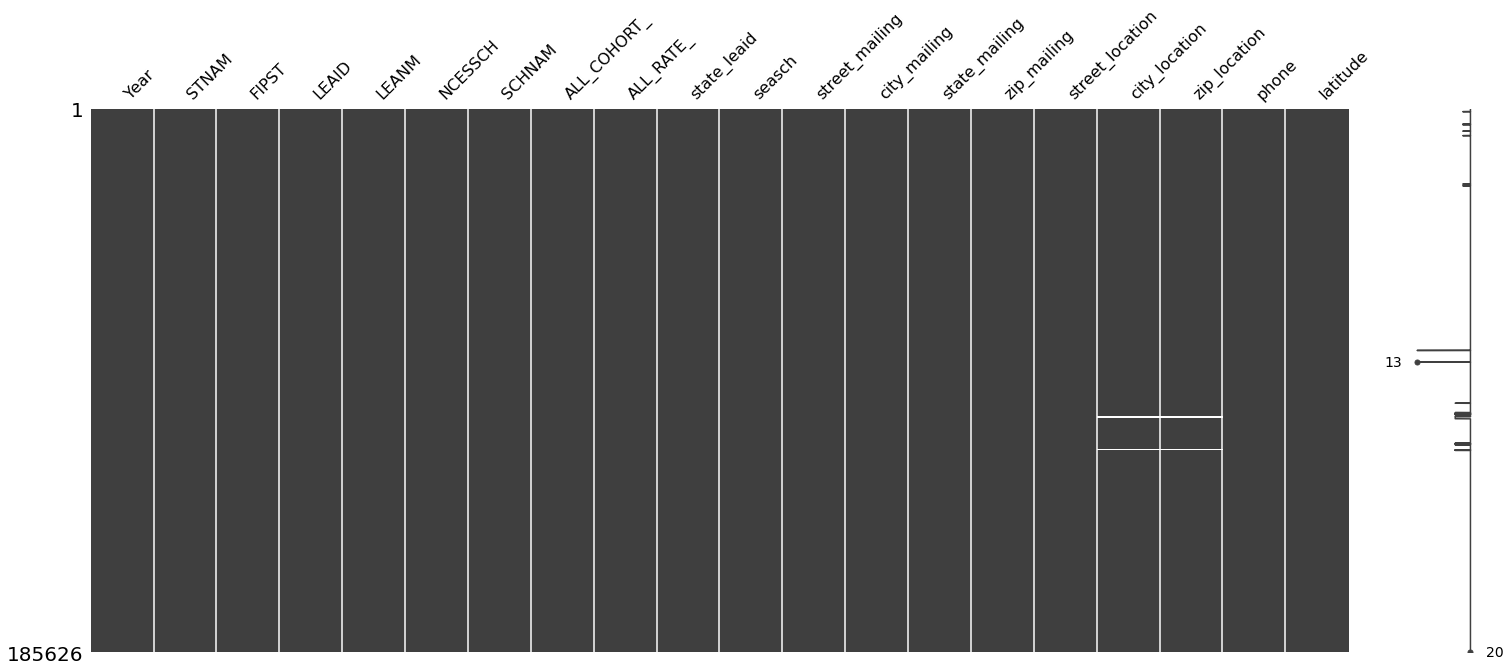

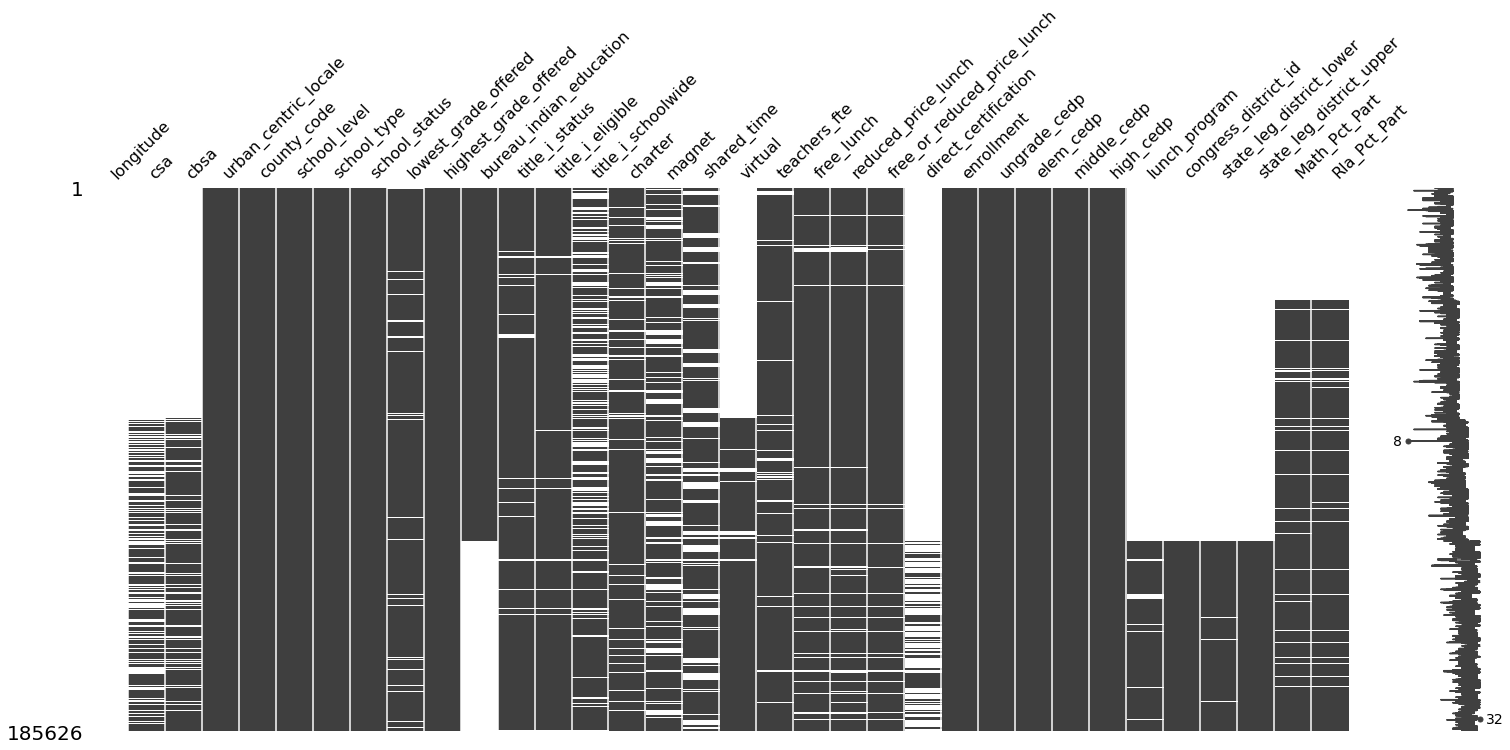

In [29]:
import missingno
missingno.matrix(gr_directory_math_rla.iloc[:,0:20])
missingno.matrix(gr_directory_math_rla.iloc[:,20:])

In [30]:
# EDA on the mega dataset formed from grad rate + directory + assessment

gr_directory_math_rla.shape

(185626, 54)

In [31]:
gr_directory_math_rla.describe()

,Year,FIPST,LEAID,NCESSCH,ALL_COHORT_,ALL_RATE_,zip_mailing,zip_location,latitude,longitude,...,direct_certification,enrollment,ungrade_cedp,elem_cedp,middle_cedp,high_cedp,lunch_program,congress_district_id,Math_Pct_Part,Rla_Pct_Part
count,185626.000000,185626.000000,1.856260e+05,1.856260e+05,185626.000000,185626.000000,185624.000000,184613.000000,185624.000000,0.0,...,23048.000000,185295.000000,185626.000000,185626.000000,185626.000000,185626.000000,61658.000000,64911.000000,137617.000000,137863.000000
mean,2014.111369,28.420528,2.853314e+06,2.853314e+11,174.212282,78.840793,53935.678000,53928.853970,38.418567,NaN,...,210.271650,740.649300,0.003049,0.090203,0.301472,0.996471,1.040287,2826.644544,92.087275,92.418597
std,2.570403,15.977442,1.597665e+06,1.597665e+11,183.715376,22.794729,28485.324961,28539.945285,5.574305,NaN,...,268.844547,750.724767,0.055135,0.286473,0.458898,0.059297,0.725710,1627.048752,11.399539,10.633718
min,2010.000000,1.000000,1.000050e+05,1.000050e+10,6.000000,0.500000,602.000000,602.000000,17.955057,NaN,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,101.000000,2.500000,2.500000
25%,2012.000000,13.000000,1.303720e+06,1.303720e+11,41.000000,75.000000,31055.000000,31036.000000,34.199022,NaN,...,35.000000,195.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1302.000000,90.000000,90.000000
50%,2014.000000,28.000000,2.803990e+06,2.803990e+11,102.000000,87.000000,54452.000000,54245.000000,39.189368,NaN,...,110.000000,464.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2802.000000,97.500000,97.500000
75%,2016.000000,41.000000,4.108100e+06,4.108100e+11,261.000000,94.000000,78234.000000,78362.000000,42.065331,NaN,...,279.000000,1096.000000,0.000000,0.000000,1.000000,1.000000,1.000000,4102.000000,97.500000,97.500000
max,2018.000000,72.000000,7.200030e+06,7.200030e+11,4788.000000,99.500000,99929.000000,99929.000000,71.300339,NaN,...,3153.000000,14319.000000,1.000000,1.000000,1.000000,1.000000,5.000000,7298.000000,99.500000,99.500000


In [32]:
gr_directory_math_rla.ALL_COHORT_.describe()

count    185626.000000
mean        174.212282
std         183.715376
min           6.000000
25%          41.000000
50%         102.000000
75%         261.000000
max        4788.000000
Name: ALL_COHORT_, dtype: float64

In [33]:
gr_directory_math_rla.teachers_fte.describe()

count    176626.000000
mean         45.495637
std          39.899619
min           0.000000
25%          15.960000
50%          32.099998
75%          67.000000
max         628.000000
Name: teachers_fte, dtype: float64

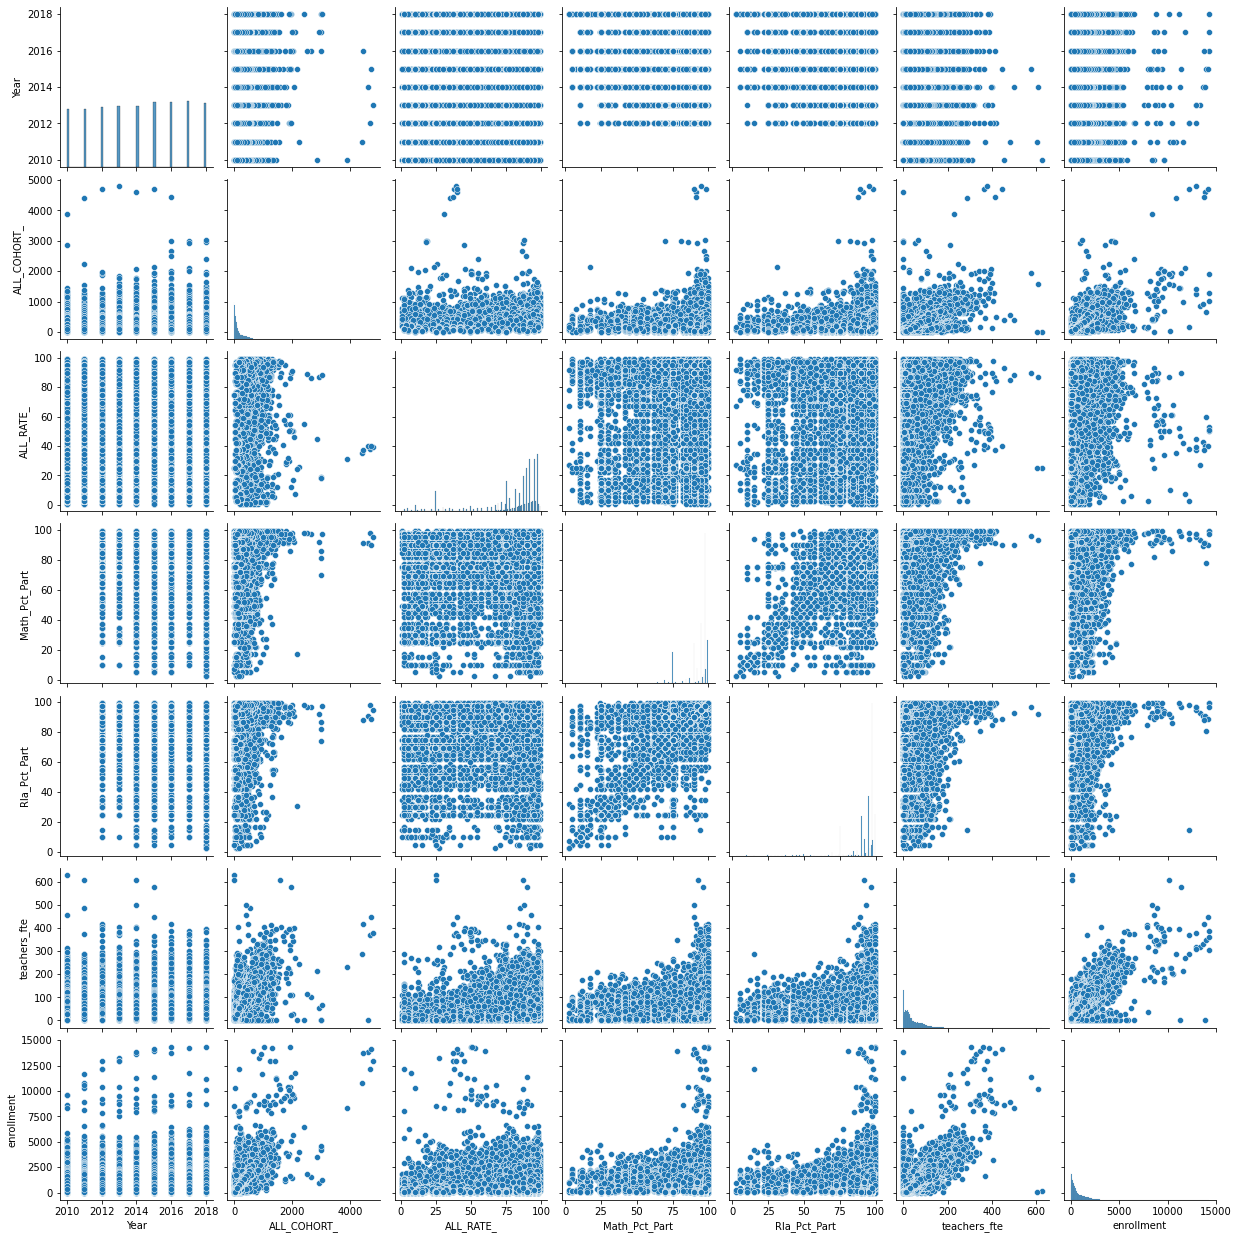

In [40]:
gr_directory_math_rla.teachers_fte[gr_directory_math_rla.teachers_fte.isnull()]
gr_directory_math_rla.teachers_fte.replace({np.nan : 0},inplace=True)
gr_directory_math_rla['teacher_ratio'] = gr_directory_math_rla.teachers_fte / gr_directory_math_rla.ALL_COHORT_
sns.pairplot(gr_directory_math_rla[['Year','ALL_COHORT_','ALL_RATE_', 'Math_Pct_Part','Rla_Pct_Part','teachers_fte','enrollment']])

In [39]:
gr_directory_math_rla.enrollment.describe()
assert sum(gr_directory_math_rla.enrollment.isnull()) == 0

AssertionError: 

In [36]:
gr_directory_math_rla.teacher_ratio.describe()

count    185626.000000
mean          0.368491
std           0.500308
min           0.000000
25%           0.203125
50%           0.269035
75%           0.389067
max          86.428571
Name: teacher_ratio, dtype: float64

<AxesSubplot:xlabel='teacher_ratio', ylabel='Count'>

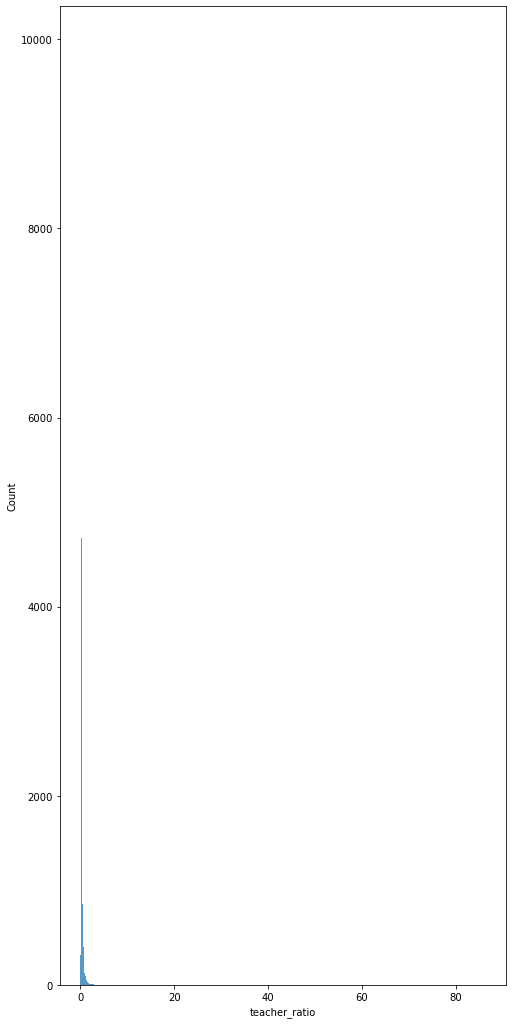

In [37]:
sns.histplot(data=gr_directory_math_rla,x='teacher_ratio')

(0.0, 0.9941544308381921)

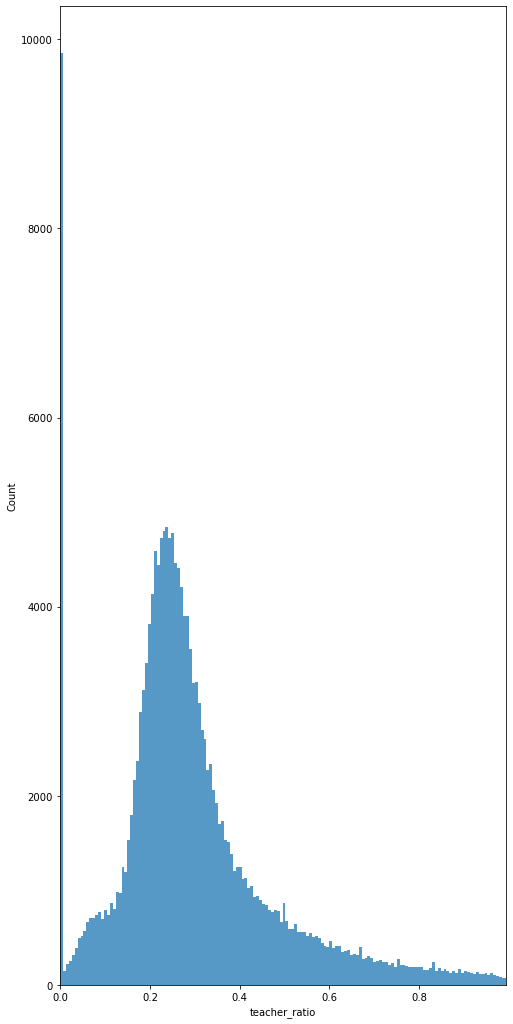

In [38]:
xlimits=np.percentile(gr_directory_math_rla.teacher_ratio,[5,95])
assert sum(gr_directory_math_rla.teacher_ratio.isnull()) == 0
sns.histplot(data=gr_directory_math_rla,x='teacher_ratio')
plt.xlim(xlimits)
plt.xlim(xlimits)